# Movie script crawler and parser

- ## Imports

In [1]:
import os, sys, json, re, argparse, urllib2, html5lib
from bs4 import BeautifulSoup, Tag, UnicodeDammit
import pandas as pd
from pandas.io.json import json_normalize
import time

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


- ### Extract functions

- ### Script loader and parser

In [2]:
#load script
script_url = 'http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html'
is_webpage_fetched = False
request_headers = {
"Accept-Language": "en-US,en;q=0.5",
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; rv:40.0) Gecko/20100101 Firefox/40.0",
#"Connection": "keep-alive" 
}


while not is_webpage_fetched:
    # get the script's URL from the parameters if it was passed
    try:
        request = urllib2.Request(script_url, headers=request_headers)
        contents = urllib2.urlopen(request)#.read()
        soup = BeautifulSoup(contents, 'lxml')
        print('Detected encoding is ', soup.original_encoding)
        is_webpage_fetched = True
    except urllib2.URLError as err:
        print('Catched an URLError while fetching the URL:', err)
        pass
    except ValueError as err:
        print('Catched a ValueError while fetching the URL:', err)
        pass
    except:
        print('Catched an unrecognized error')
        raise
    else:
        #script_text = soup.find("td", class_="scrtext").find("pre")
        script_text = soup.find("pre")

        if( script_text.find("pre") ):
            print('Found a <pre> inside the <pre>')
            script_text = script_text.find("pre")

        print('Parsing {} and extracting the first <pre> resulted in the following text:'.format(script_url))
        print(str(script_text)[:256])
        is_webpage_fetched = True




print('\n \n OK, we have the text. A few questions before we get parsing:')

('Detected encoding is ', u'iso-8859-1')
Parsing http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html and extracting the first <pre> resulted in the following text:
<pre>

 
<b>                               STAR WARS: THE FORCE AWAKENS
</b>
                         

                         

                                       Written by

                         
                      Lawrence Kasda

 
 OK, we have the text. A few questions before we get parsing:


- ### White space analysis

In [3]:
def white_space_analysis(script_text):
    spaces_regex = re.compile("^(\s*).*")
    space_vector=[]

    for block in script_text.descendants:
        # Si block est une instance de bs4.Tag, il est entouré de balises HTML
        # Le prochain block contiendra le même texte sans les balises
        # Donc on continue sans parser ce bloc
        if(isinstance(block, Tag)):
            continue

        # UnicodeDammit converts any string to UTF-8
        # does not work so well
        block = UnicodeDammit(block, soup.original_encoding).unicode_markup
        # remove leading and ending end of lines
        block = block.strip('\n').strip('\r\n')

        # if the block doesn't have any text, skip it
        if( re.search('\w', block) == None ):
            continue

        for line in block.split('\n'):
            stripped_line = line.strip(' \n\t\r')
            if( re.search('\w', line) == None ):
                continue    
            # Counting the number of spaces at the beginning of the line
            spmatch = spaces_regex.search(line)
            space_vector.append(len(spmatch.group(1)))

    return space_vector

In [4]:
space_vector = white_space_analysis(script_text)

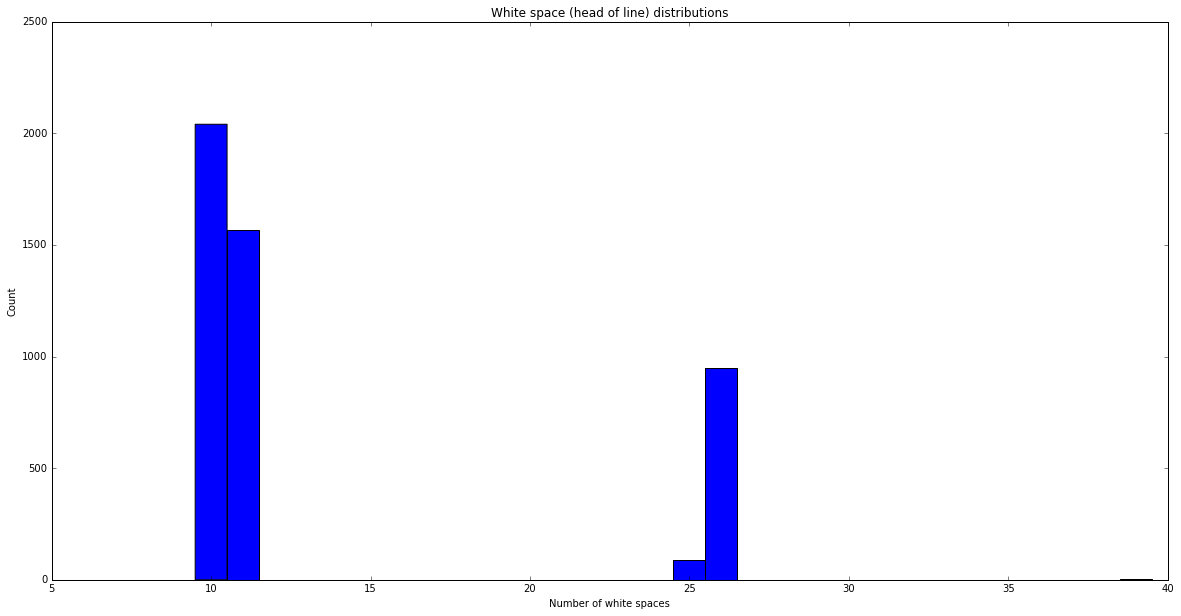

In [5]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

space_vector_=np.array(space_vector)
plt.figure(figsize=(20,10))
plt.hist(space_vector_, bins=np.arange(space_vector_.min(), space_vector_.max()+1)-0.5)
plt.title('White space (head of line) distributions')
plt.xlabel('Number of white spaces')
plt.ylabel('Count')


In [6]:
from collections import Counter
Counter(space_vector)

    #all the occurences except the top 3 are occurences from global stage references

Counter({10: 2041,
         11: 1565,
         22: 1,
         23: 1,
         25: 88,
         26: 947,
         31: 1,
         36: 1,
         39: 2,
         40: 1})

In [7]:
sorted(Counter(space_vector),key=Counter(space_vector).get,reverse=True)

[10, 11, 26, 25, 39, 36, 40, 22, 23, 31]

## Parsing functions

In [8]:
def get_script(url):
    #load script
    script_url = url
    is_webpage_fetched = False
    request_headers = {
    "Accept-Language": "en-US,en;q=0.5",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; rv:40.0) Gecko/20100101 Firefox/40.0",
    #"Connection": "keep-alive" 
    }


    while not is_webpage_fetched:
        # get the script's URL from the parameters if it was passed
        try:
            request = urllib2.Request(script_url, headers=request_headers)
            contents = urllib2.urlopen(request)#.read()
            soup = BeautifulSoup(contents, 'lxml')
            print('Detected encoding is ', soup.original_encoding)
            is_webpage_fetched = True
        except urllib2.URLError as err:
            print('Catched an URLError while fetching the URL:', err)
            pass
        except ValueError as err:
            print('Catched a ValueError while fetching the URL:', err)
            pass
        except:
            print('Catched an unrecognized error')
            raise
        else:
            #script_text = soup.find("td", class_="scrtext").find("pre")
            script_text = soup.find("pre")

            if( script_text.find("pre") ):
                print('Found a <pre> inside the <pre>')
                script_text = script_text.find("pre")
            is_webpage_fetched = True
    print('Getting script @ %s.' %(url))
    return script_text


def white_space_analysis(script_text):
    spaces_regex = re.compile("^(\s*).*")
    space_vector=[]

    for block in script_text.descendants:
        # Si block est une instance de bs4.Tag, il est entouré de balises HTML
        # Le prochain block contiendra le même texte sans les balises
        # Donc on continue sans parser ce bloc
        if(isinstance(block, Tag)):
            continue

        # UnicodeDammit converts any string to UTF-8
        # does not work so well
        block = UnicodeDammit(block, soup.original_encoding).unicode_markup
        # remove leading and ending end of lines
        block = block.strip('\n').strip('\r\n')

        # if the block doesn't have any text, skip it
        if( re.search('\w', block) == None ):
            continue

        for line in block.split('\n'):
            stripped_line = line.strip(' \n\t\r')
            if( re.search('\w', line) == None ):
                continue    
            # Counting the number of spaces at the beginning of the line
            spmatch = spaces_regex.search(line)
            space_vector.append(len(spmatch.group(1)))

    return space_vector


def identify_usual_spaces(space_vector):
    a=Counter(space_vector)
    b=sorted(a,key=a.get,reverse=True)
    ratio=float((a[b[0]]+a[b[1]]+a[b[2]]+a[b[3]]))/float(len(space_vector))
    #print(ratio)
    if ratio > 0.9:
        usual_spaces=[[b[2]],[b[1]],[b[0]],[b[3]],[]]
        return  usual_spaces,True
    else:
        print('This script is too unstable to parse')
        usual_spaces=[[b[2]],[b[1]],[b[0]],[b[3]],[]]
        return usual_spaces,False

def write_csv(data,name,path):
    #if folder does not exist
    if not os.path.exists(path):
        os.makedirs(path)
    data.to_csv('%s%s.csv' %(path,name),sep='|',encoding='latin1')
    return

def get_line_type(line, stripped_line, usual_spaces):
    # Counting the number of spaces at the beginning of the line
    spaces_regex = re.compile("^(\s*).*")
    location_regex = re.compile("^\s*(INT\.|EXT\.)")
    BLOCK_TYPES=['character', 'speech', 'stage direction', 'location','unknown']
    CHARACTER=0
    SPEECH=1
    DIRECTIONS=2
    LOCATION=3
    
    spmatch = spaces_regex.search(line)
    spaces_number = len(spmatch.group(1))
    block_type = 4

    if( location_regex.search(line) != None ):
        #print('location')
        return LOCATION

    #if stripped_line in characters:
        #print(character)
        #return CHARACTER

    # Look for space
    for block_type_usual_spaces in usual_spaces:
        if spaces_number in block_type_usual_spaces:
            block_type = usual_spaces.index(block_type_usual_spaces)
            #print('We consider {:d} leading spaces as a \'{:s}\' block.'.format(
            #      spaces_number, BLOCK_TYPES[block_type]))
            #print(BLOCK_TYPES[block_type])
            return usual_spaces.index(block_type_usual_spaces)
            

      
    #print('failure for identifying : %s categorizing it as unknown' %(repr(line)))
    return block_type #return code 5 for unknown


In [9]:
def parse(url,path,name):
    #init variables
    spaces_regex = re.compile("^(\s*).*")
    location_regex = re.compile("^\s*(INT\.|EXT\.)")

    BLOCK_TYPES=['character', 'speech', 'stage direction', 'location','unknown']
    CHARACTER=0
    SPEECH=1
    DIRECTIONS=2
    LOCATION=3
    
    time_start=time.time()
    
    if url.endswith('.pdf'):
        print('The file @ %s is a PDF' %(url))
        return
    
    script_text=get_script(url)
    space_vector = white_space_analysis(script_text)
    usual_spaces,flag=identify_usual_spaces(space_vector)

    # Ici on définit les variables qu'on remplira de texte
    is_intro = True
    movie_script = []
    intro = []
    last_line_type = -1
    last_character = 'unknown'
    text = []
    characters=[]

    for block in script_text.descendants:
        # Si block est une instance de bs4.Tag, il est entouré de balises HTML
        # Le prochain block contiendra le même texte sans les balises
        # Donc on continue sans parser ce bloc
        if(isinstance(block, Tag)):
            continue

        # UnicodeDammit converts any string to UTF-8
        # does not work so well
        block = UnicodeDammit(block, soup.original_encoding).unicode_markup
        # remove leading and ending end of lines
        block = block.strip('\n').strip('\n\r')

        # if the block doesn't have any text, skip it
        if( re.search('\w', block) == None ):
            continue

        for line in block.split('\n'):
            stripped_line = line.strip(' \n\t\r')
            if( re.search('\w', line) == None ):
                continue    
            # Counting the number of spaces at the beginning of the line
            spmatch = spaces_regex.search(line)
            space_vector.append(len(spmatch.group(1)))
            #print(block)
            #print(line)
            #print(len(spmatch.group(1)))
            line_type = get_line_type(line, stripped_line, usual_spaces)
            #print(line_type)
            #print(line)

            if(last_line_type == -1 # -1 = not initialized
               or last_line_type == line_type):
                text.append(stripped_line)
            else:
                if(last_line_type == CHARACTER):
                    last_character='\n'.join(text) #regex to supress (parenthesis) & replicate speaker
                    if not last_character in characters:
                        characters.append(last_character)
                elif(last_line_type == SPEECH):
                    movie_script.append({
                        'type': BLOCK_TYPES[last_line_type],
                        BLOCK_TYPES[CHARACTER]: last_character,
                        'text': '\n'.join(text)})
                    #print('We just parsed this JSON block:')
                    #print(movie_script[-1])
                else:
                    movie_script.append({
                        'type': BLOCK_TYPES[last_line_type],
                        'text': '\n'.join(text)})
                    #print('We just parsed this JSON block:')
                    #print(movie_script[-1])
                text=[stripped_line]

            last_line_type = line_type
            #print('----------------')

    result = json_normalize(movie_script)
    if flag:
        write_csv(result,name,path)
        print('      Done parsing script at %s in %s' %(url,time.time()-time_start))
        print('-----------------')
        return(result)
    else:
        path=path+'doubtful/'
        write_csv(result,name,path)
        print('      Done parsing script at %s in %s' %(url,time.time()-time_start))
        print('-----------------')
        return(result)

In [10]:
%%time

url='http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html'
path='../data/script/'
name='Starwars'
test=parse(url,path,name)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
      Done parsing script at http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html in 2.44874811172
-----------------
CPU times: user 188 ms, sys: 8 ms, total: 196 ms
Wall time: 2.45 s


In [11]:
test

,character,text,type
0,NaN,STAR WARS: THE FORCE AWAKENS\nWritten by\nLawr...,unknown
1,NaN,"A long time ago in a galaxy far, far away...",stage direction
2,NaN,STAR WARS\nEPISODE VII\nTHE FORCE AWAKENS,unknown
3,unknown,"Luke Skywalker has vanished. In his absence,\n...",speech
4,NaN,PAN across the star field to a bright moon. A ...,stage direction
5,NaN,ARE IN:\nINT. TROOP TRANSPORT VEHICLE - NIGHT,location
6,NaN,"TWENTY STORMTROOPERS. Holding on at attention,...",stage direction
7,NaN,QUIET:\nEXT. JAKKU VILLAGE - NIGHT,location
8,NaN,"WIDE SHOT of a small, peaceful village. Distan...",stage direction
9,NaN,INT. LARGE HUT - NIGHT,location


In [12]:
urls=['http://www.imsdb.com/scripts/La-La-Land.html','http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html',
      'http://www.imsdb.com/scripts/V-for-Vendetta.html']
output=[]

for url in urls:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output.append(test)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/La-La-Land.html.
This script is too unstable to parse
      Done parsing script at http://www.imsdb.com/scripts/La-La-Land.html in 1.90941309929
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
      Done parsing script at http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html in 2.50909900665
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/V-for-Vendetta.html.
      Done parsing script at http://www.imsdb.com/scripts/V-for-Vendetta.html in 3.21471095085
-----------------


In [13]:
output_=[]

for url in urls:
    script_text=get_script(url)
    space_vector = white_space_analysis(script_text)
    usual_spaces=identify_usual_spaces(space_vector)
    output_.append(space_vector)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/La-La-Land.html.
This script is too unstable to parse
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/V-for-Vendetta.html.


In [15]:
def white_space_analysis(script_text):
    spaces_regex = re.compile("^(\s*).*")
    space_vector=[]
    character_presence=[]

    for block in script_text.descendants:
        # Si block est une instance de bs4.Tag, il est entouré de balises HTML
        # Le prochain block contiendra le même texte sans les balises
        # Donc on continue sans parser ce bloc
        if(isinstance(block, Tag)):
            continue

        # UnicodeDammit converts any string to UTF-8
        # does not work so well
        block = UnicodeDammit(block, soup.original_encoding).unicode_markup
        # remove leading and ending end of lines
        block = block.strip('\n').strip('\r\n')

        # if the block doesn't have any text, skip it
        if( re.search('\w', block) == None ):
            continue

        for line in block.split('\n'):
            stripped_line = line.strip(' \n\t\r')
            if( re.search('\w', line) == None ):
                continue    
            # Counting the number of spaces at the beginning of the line
            spmatch = spaces_regex.search(line)
            space_vector.append(len(spmatch.group(1)))
            if (stripped_line.isupper()) & (len(stripped_line.split(' '))<=3):
                character_presence.append(len(spmatch.group(1)))

            else:
                character_presence.append(None)
                                            


            
    return space_vector,character_presence #,speech_presence


def identify_usual_spaces(space_vector,character_presence):
    #identify space for characters
    c=Counter([a for a in character_presence if a])
    char=sorted(c,key=c.get,reverse=True)[0]
    #identify space for speech
    indexes=[index+1 for index, value in enumerate(space_vector) if value == char]
    del indexes[-1]
    speech_presence=[space_vector[a] for a in indexes]
    c=Counter([a for a in speech_presence if a])
    speech=sorted(c,key=c.get,reverse=True)[0]
    #compute ratio
    a=Counter(space_vector)
    other=Counter([e for e in space_vector if e!=char and e!=speech])
    b=sorted(other,key=other.get,reverse=True)
    ratio=float((a[char]+a[speech]+a[b[0]]+a[b[1]]))/float(len(space_vector))
    #print(ratio)
    if ratio > 0.9:
        usual_spaces=[[char],[speech],[b[0]],[b[1]],[]]
        return  usual_spaces,True
    else:
        print('This script is too unstable to parse')
        usual_spaces=[[char],[speech],[b[0]],[b[1]],[]]
        return usual_spaces,False

def parse(url,path,name):
    #init variables
    spaces_regex = re.compile("^(\s*).*")
    location_regex = re.compile("^\s*(INT\.|EXT\.)")

    BLOCK_TYPES=['character', 'speech', 'stage direction', 'location','unknown']
    CHARACTER=0
    SPEECH=1
    DIRECTIONS=2
    LOCATION=3
    
    time_start=time.time()
    
    if url.endswith('.pdf'):
        print('The file @ %s is a PDF' %(url))
        return
    
    script_text=get_script(url)
    space_vector,character_presence = white_space_analysis(script_text)
    usual_spaces,flag=identify_usual_spaces(space_vector,character_presence)

    # Ici on définit les variables qu'on remplira de texte
    is_intro = True
    movie_script = []
    intro = []
    last_line_type = -1
    last_character = 'unknown'
    text = []
    characters=[]

    for block in script_text.descendants:
        # Si block est une instance de bs4.Tag, il est entouré de balises HTML
        # Le prochain block contiendra le même texte sans les balises
        # Donc on continue sans parser ce bloc
        if(isinstance(block, Tag)):
            continue

        # UnicodeDammit converts any string to UTF-8
        # does not work so well
        block = UnicodeDammit(block, soup.original_encoding).unicode_markup
        # remove leading and ending end of lines
        block = block.strip('\n').strip('\n\r')

        # if the block doesn't have any text, skip it
        if( re.search('\w', block) == None ):
            continue

        for line in block.split('\n'):
            stripped_line = line.strip(' \n\t\r')
            if( re.search('\w', line) == None ):
                continue    
            # Counting the number of spaces at the beginning of the line
            spmatch = spaces_regex.search(line)
            space_vector.append(len(spmatch.group(1)))
            #print(block)
            #print(line)
            #print(len(spmatch.group(1)))
            line_type = get_line_type(line, stripped_line, usual_spaces)
            #print(line_type)
            #print(line)

            if(last_line_type == -1 # -1 = not initialized
               or last_line_type == line_type):
                text.append(stripped_line)
            else:
                if(last_line_type == CHARACTER):
                    last_character='\n'.join(text) #regex to supress (parenthesis) & replicate speaker
                    if not last_character in characters:
                        characters.append(last_character)
                elif(last_line_type == SPEECH):
                    movie_script.append({
                        'type': BLOCK_TYPES[last_line_type],
                        BLOCK_TYPES[CHARACTER]: last_character,
                        'text': '\n'.join(text)})
                    #print('We just parsed this JSON block:')
                    #print(movie_script[-1])
                else:
                    movie_script.append({
                        'type': BLOCK_TYPES[last_line_type],
                        'text': '\n'.join(text)})
                    #print('We just parsed this JSON block:')
                    #print(movie_script[-1])
                text=[stripped_line]

            last_line_type = line_type
            #print('----------------')

    result = json_normalize(movie_script)
    if flag:
        write_csv(result,name,path)
        print('      Done parsing script at %s in %s' %(url,time.time()-time_start))
        print('-----------------')
        return(result)
    else:
        path=path+'doubtful/'
        write_csv(result,name,path)
        print('      Done parsing script at %s in %s' %(url,time.time()-time_start))
        print('-----------------')
        return(result)

In [16]:
urls=['http://www.imsdb.com/scripts/La-La-Land.html','http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html',
      'http://www.imsdb.com/scripts/V-for-Vendetta.html']
output=[]

for url in urls:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output.append(test)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/La-La-Land.html.
This script is too unstable to parse
      Done parsing script at http://www.imsdb.com/scripts/La-La-Land.html in 1.90995502472
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
      Done parsing script at http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html in 2.49408793449
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/V-for-Vendetta.html.
      Done parsing script at http://www.imsdb.com/scripts/V-for-Vendetta.html in 3.1854300499
-----------------


In [19]:
output[1]

,character,text,type
0,NaN,STAR WARS: THE FORCE AWAKENS\nWritten by\nLawr...,unknown
1,NaN,"A long time ago in a galaxy far, far away...",stage direction
2,NaN,STAR WARS\nEPISODE VII\nTHE FORCE AWAKENS,unknown
3,unknown,"Luke Skywalker has vanished. In his absence,\n...",speech
4,NaN,PAN across the star field to a bright moon. A ...,stage direction
5,NaN,ARE IN:\nINT. TROOP TRANSPORT VEHICLE - NIGHT,location
6,NaN,"TWENTY STORMTROOPERS. Holding on at attention,...",stage direction
7,NaN,QUIET:\nEXT. JAKKU VILLAGE - NIGHT,location
8,NaN,"WIDE SHOT of a small, peaceful village. Distan...",stage direction
9,NaN,INT. LARGE HUT - NIGHT,location


In [18]:
output[2]

,character,text,type
0,NaN,V FOR VENDETTA\nWritten by\nLarry and Andy Wac...,unknown
1,NaN,"FADE IN:\nIn the darkness, we hear a voice, a ...",stage direction
2,EVEY (V.O.),"""Remember, remember, the fifth of\nNovember, t...",speech
3,NaN,Her voice has a strength that is metered by a ...,stage direction
4,EVEY (V.O.),Those were almost the very first\nwords he spo...,speech
5,NaN,"In the darkness, we find a lantern. Guy Fawke...",stage direction
6,EVEY (V.O.),"In 1605, Guy Fawkes attempted to\nblow up the ...",speech
7,NaN,The wheelbarrow bumps over the heavy stone mor...,stage direction
8,EVEY (V.O.),He was caught in the cellars with\nenough gunp...,speech
9,NaN,Guy sees lanterns coming from both sides. He ...,stage direction
